# Import Libraries

In [1]:
# ==== Standard libraries ====
import os
import re
import math

# ==== Data manipulation ====
import pandas as pd
import numpy as np

# ==== Spotify API ====
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ==== Machine Learning: Model selection & evaluation ====
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance

# ==== Machine Learning: Models ====
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# ==== Preprocessing and Feature Engineering ====
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# ==== Pipeline ====
from sklearn.pipeline import Pipeline

# Define Functions

In [2]:
# =============================
# Define Functions
# =============================

# --- Artist Parsing Functions ---

def count_artists(artist_name):
    if pd.isna(artist_name):
        return 0
    artist_name = artist_name.lower()
    artist_name = re.sub(r'feat\.|ft\.|&|/', ',', artist_name)
    artists = [a.strip() for a in artist_name.split(',') if a.strip()]
    return len(artists)

def get_main_artist(artist_name):
    if pd.isna(artist_name):
        return None
    artist_name = artist_name.lower()
    artist_name = re.sub(r'\(.*?\)|\[.*?\]', '', artist_name)
    artist_name = re.sub(r'feat\.|ft\.|featuring|&|/', ',', artist_name)
    artists = [a.strip() for a in artist_name.split(',') if a.strip()]
    return artists[0] if artists else None

def format_main_artist(artist_name):
    if pd.isna(artist_name):
        return None
    return ' '.join(word.capitalize() for word in artist_name.split())

In [3]:
# --- Spotify Metadata Fetching ---

def fetch_artist_metadata(sp, artist_names):
    artist_features = []
    for artist_name in artist_names:
        try:
            result = sp.search(q=f'artist:{artist_name}', type='artist', limit=1)
            if result['artists']['items']:
                artist_info = result['artists']['items'][0]
                genres = artist_info['genres']
                if not genres:
                    related = sp.artist_related_artists(artist_info['id'])['artists']
                    related_genres = []
                    for rel_artist in related:
                        related_genres.extend(rel_artist['genres'])
                    genres = [pd.Series(related_genres).mode()[0]] if related_genres else ["Unknown"]
                artist_features.append({
                    'main_artist': artist_name,
                    'followers': artist_info['followers']['total'],
                    'popularity': artist_info['popularity'],
                    'genres': ", ".join(genres)
                })
            else:
                artist_features.append({
                    'main_artist': artist_name,
                    'followers': None,
                    'popularity': None,
                    'genres': "Unknown"
                })
        except Exception:
            artist_features.append({
                'main_artist': artist_name,
                'followers': None,
                'popularity': None,
                'genres': "Unknown"
            })
    return pd.DataFrame(artist_features)

In [4]:
# --- Manual Imputation for Debugging or Missing Cases ---

def get_artist_info(sp, artist_name):
    try:
        result = sp.search(q=f'artist:{artist_name}', type='artist', limit=1)
        if result['artists']['items']:
            artist_info = result['artists']['items'][0]
            followers = artist_info['followers']['total']
            popularity = artist_info['popularity']
            genres = artist_info['genres']
            return {
                'Artist Name': artist_info['name'],
                'Followers': followers,
                'Popularity': popularity,
                'Genres': ", ".join(genres) if genres else "Unknown"
            }
        else:
            return {'Error': 'Artist not found'}
    except Exception as e:
        return {'Error': str(e)}

In [5]:
# --- PCA Loadings Helper ---

def top_loadings(pc, names, n=5):
    idx = np.argsort(np.abs(pc))[-n:][::-1]
    return pd.DataFrame({
        'Feature': [names[i].split('__')[-1] for i in idx],
        'Loading': pc[idx]
    })

In [6]:
# --- Permutation Importance Helper ---

def plot_perm(model, X, y, feat_names, title):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1, scoring='precision')
    idx = result.importances_mean.argsort()[::-1][:10]
    return pd.DataFrame({
        'Feature': [f.split('__')[-1] for f in np.array(feat_names)[idx]],
        'Importance': result.importances_mean[idx]
    })

In [7]:
# --- Run Pipeline ---

def run_pipeline(numerical_feats, label):
    all_feats = numerical_feats + categorical_features + binary_features
    X = df1[all_feats]
    y = df1['popularity_binary']

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_feats),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

    X_proc = preprocessor.fit_transform(X)

    # --- PCA ---
    pca = PCA()
    X_pca = pca.fit_transform(X_proc)
    num_components_90 = (np.cumsum(pca.explained_variance_ratio_) >= 0.90).argmax() + 1
    X_pca_reduced = X_pca[:, :num_components_90]

    # --- Scree Plot ---
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='#00cb5e', alpha=0.8, label='Explained Variance')
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, color='black', marker='o', label='Cumulative Explained Variance')
    plt.axvline(x=num_components_90, color='#666666', linestyle='--', linewidth=1)
    plt.scatter(num_components_90, cumulative_variance[num_components_90 - 1], color='black', zorder=5)
    plt.text(num_components_90 + 0.3, cumulative_variance[num_components_90 - 1] - 0.05,
             f"{cumulative_variance[num_components_90 - 1]*100:.1f}%", fontsize=10)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.title(f'PCA Explained Variance – {label}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- PC1 and PC2 Loadings ---
    feature_names = preprocessor.get_feature_names_out()
    for idx, pc in enumerate([pca.components_[0], pca.components_[1]]):
        df_pc = top_loadings(pc, feature_names)
        plt.figure(figsize=(8, 4))
        plt.barh(df_pc['Feature'], df_pc['Loading'], color='#00cb5e')
        plt.title(f'{label}: PC{idx+1} Top 5 Loadings')
        plt.axvline(0, color='gray')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    # --- Model training ---
    results_no_pca, results_pca = [], []
    best_dt = None

    for name, (estimator, param_grid) in models_and_grids.items():
        # No PCA
        pipe_no_pca = Pipeline([('preprocessor', preprocessor), ('clf', estimator)])
        grid_no_pca = GridSearchCV(pipe_no_pca, param_grid, cv=cv, scoring=scoring, refit='accuracy', n_jobs=-1)
        grid_no_pca.fit(X, y)
        idx_np = grid_no_pca.best_index_
        results_no_pca.append({
            'Model': name,
            f'Acc_{label}_NoPCA': grid_no_pca.best_score_,
            f'Prec_{label}_NoPCA': grid_no_pca.cv_results_['mean_test_precision'][idx_np],
            f'Recall_{label}_NoPCA': grid_no_pca.cv_results_['mean_test_recall'][idx_np]
        })
        if name == 'Decision Tree':
            best_dt = grid_no_pca.best_estimator_

        # With PCA
        pipe_pca = Pipeline([('clf', estimator)])
        grid_pca = GridSearchCV(pipe_pca, param_grid, cv=cv, scoring=scoring, refit='accuracy', n_jobs=-1)
        grid_pca.fit(X_pca_reduced, y)
        idx_pca = grid_pca.best_index_
        results_pca.append({
            'Model': name,
            f'Acc_{label}_PCA': grid_pca.best_score_,
            f'Prec_{label}_PCA': grid_pca.cv_results_['mean_test_precision'][idx_pca],
            f'Recall_{label}_PCA': grid_pca.cv_results_['mean_test_recall'][idx_pca]
        })

    return pd.DataFrame(results_no_pca), pd.DataFrame(results_pca), best_dt, X, y, preprocessor.get_feature_names_out()

In [8]:
def plot_biplot(X_pca, y, components, feature_names, label):
    plt.figure(figsize=(10, 8))

    # Subtle scatter points for observations
    plt.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c='lightgrey', s=20, alpha=0.5,
        edgecolor='none'
    )

    # Feature vectors (loadings)
    scale = 5  # Controls arrow length scaling
    for i in range(len(feature_names)):
        x_vec = components[0, i] * scale
        y_vec = components[1, i] * scale
        feature = feature_names[i].split('__')[-1]

        plt.arrow(
            0, 0, x_vec, y_vec,
            color='#00cb5e', alpha=0.9,
            head_width=0.2, linewidth=2
        )
        plt.text(
            x_vec * 1.3, y_vec * 1.3,
            feature,
            fontsize=10, ha='center', va='center'
        )

    # Axis styling
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Biplot: PC1 vs PC2 – {label}', fontsize=14)
    plt.grid(alpha=0.3)
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')
    plt.tight_layout()
    plt.show()

# Data Collection

In [9]:
# =============================
# Data Collection
# =============================

if not os.path.exists("final.csv"):
    # Load original dataset
    df = pd.read_csv("top_spotify_songs.csv")

    # Drop unnecessary columns
    df.drop(columns=[
        'spotify_id', 'daily_rank', 'daily_movement', 'weekly_movement',
        'country', 'album_name'
    ], inplace=True)

    # Convert date columns
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], errors='coerce')
    df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')

    # Keep only rows within 7 days of album release
    df['days_diff'] = (df['snapshot_date'] - df['album_release_date']).dt.days
    df = df[(df['days_diff'] >= 0) & (df['days_diff'] <= 7)].copy()
    df.drop(columns='days_diff', inplace=True)

    # Drop duplicates and limit by date
    df = df.drop_duplicates()
    df = df[df['snapshot_date'] >= pd.Timestamp("2025-03-17")]

    # Extract artist info
    df['num_artists'] = df['artists'].apply(count_artists)
    df['main_artist'] = df['artists'].apply(get_main_artist).apply(format_main_artist)

    # Spotify Authentication
    client_id = '61583584bd1444a79e6d879e91b5ad1a'
    client_secret = '03df22c6cf6c43259d80635ddde328af'
    auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(auth_manager=auth_manager)

    # Get artist metadata
    artist_features_df = fetch_artist_metadata(sp, df['main_artist'].dropna().unique())
    df = df.merge(artist_features_df, on='main_artist', how='left')

    df.to_csv("final.csv", index=False)
    print("✅ Final dataset saved as final.csv")
else:
    print("✅ Skipped processing: final.csv already exists.")

✅ Skipped processing: final.csv already exists.


# Manual Imputation

In [10]:
# =============================
# Manual Imputation
# =============================

if not os.path.exists("final.csv"):
    client_id = '61583584bd1444a79e6d879e91b5ad1a'
    client_secret = '03df22c6cf6c43259d80635ddde328af'
    auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(auth_manager=auth_manager)

    # Example manual lookup
    artist_data = get_artist_info(sp, "Noize Mc")
    print(pd.DataFrame([artist_data]))

    # Using known Spotify artist ID
    artist_id = '3BR3Qfra04DICDUB2BL3eu'
    artist_info = sp.artist(artist_id)

    print({
        'Artist Name': artist_info['name'],
        'Followers': artist_info['followers']['total'],
        'Popularity': artist_info['popularity'],
        'Genres': ", ".join(artist_info['genres']) if artist_info['genres'] else "Unknown"
    })
else:
    print("✅ Skipped manual lookup: final.csv already exists.")

✅ Skipped manual lookup: final.csv already exists.


# Exploratory Data Analysis

In [11]:
# =============================
# Exploratory Data Analysis
# =============================

df = pd.read_csv("final.csv")

# Drop YouTube or unnecessary columns if present
df.drop(columns=[
    'views', 'likes', 'comments', 'video_title', 'channel',
    'video_url', 'track', 'artist', 'has_youtube_match', 'genres',
    'num_artists'
], errors='ignore', inplace=True)

df['is_explicit'] = df['is_explicit'].astype(int)

# Rename for clarity
df = df.rename(columns={
    'popularity_x': 'song_popularity',
    'popularity_y': 'artist_popularity',
})

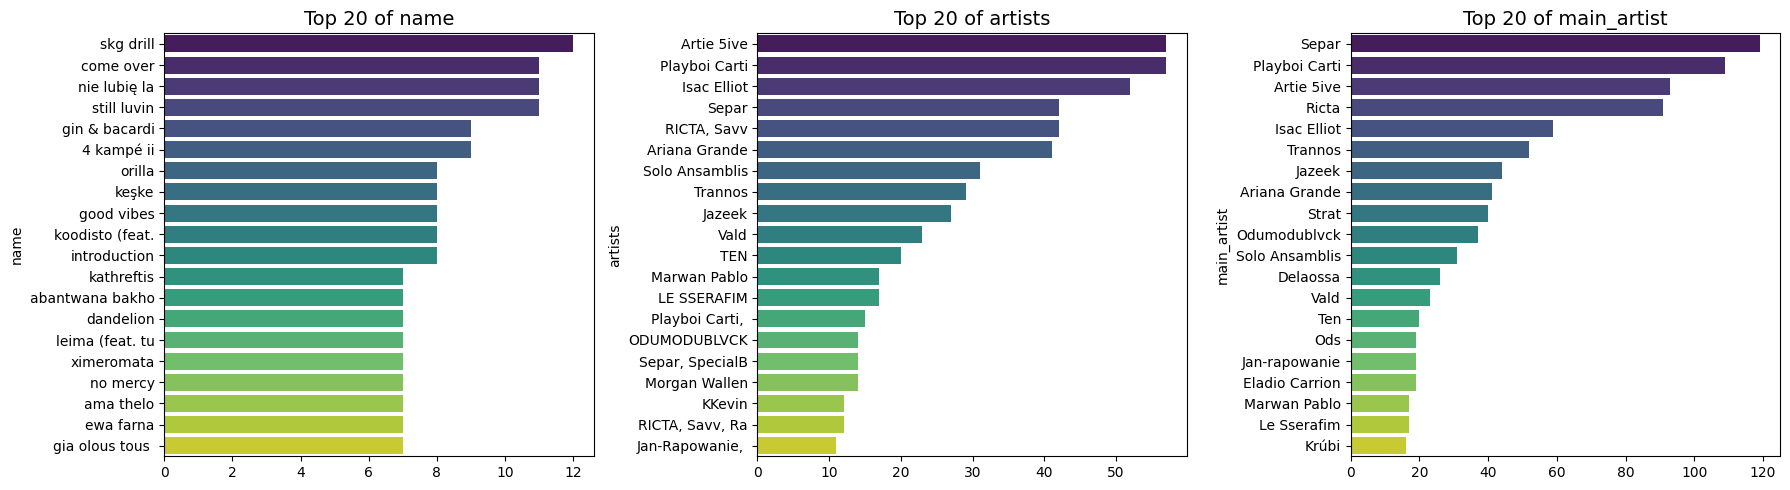

In [12]:
# # --- Categorical plots ---
# top_n = 20
# cols = 3
# categorical_cols = df.select_dtypes(include='object').columns.tolist()
# categorical_cols = [col for col in categorical_cols if col not in ['snapshot_date', 'album_release_date']]
# rows = math.ceil(len(categorical_cols) / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
# axes = axes.flatten()

# for i, col in enumerate(categorical_cols):
#     top_categories = df[col].value_counts().head(top_n)
#     top_categories.index = top_categories.index.str.slice(0, 15)
#     sns.barplot(
#         x=top_categories.values,
#         y=top_categories.index,
#         hue=top_categories.index,
#         dodge=False,
#         legend=False,
#         ax=axes[i],
#         palette='viridis'
#     )
#     axes[i].set_title(f'Top {top_n} of {col}', fontsize=14)

# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

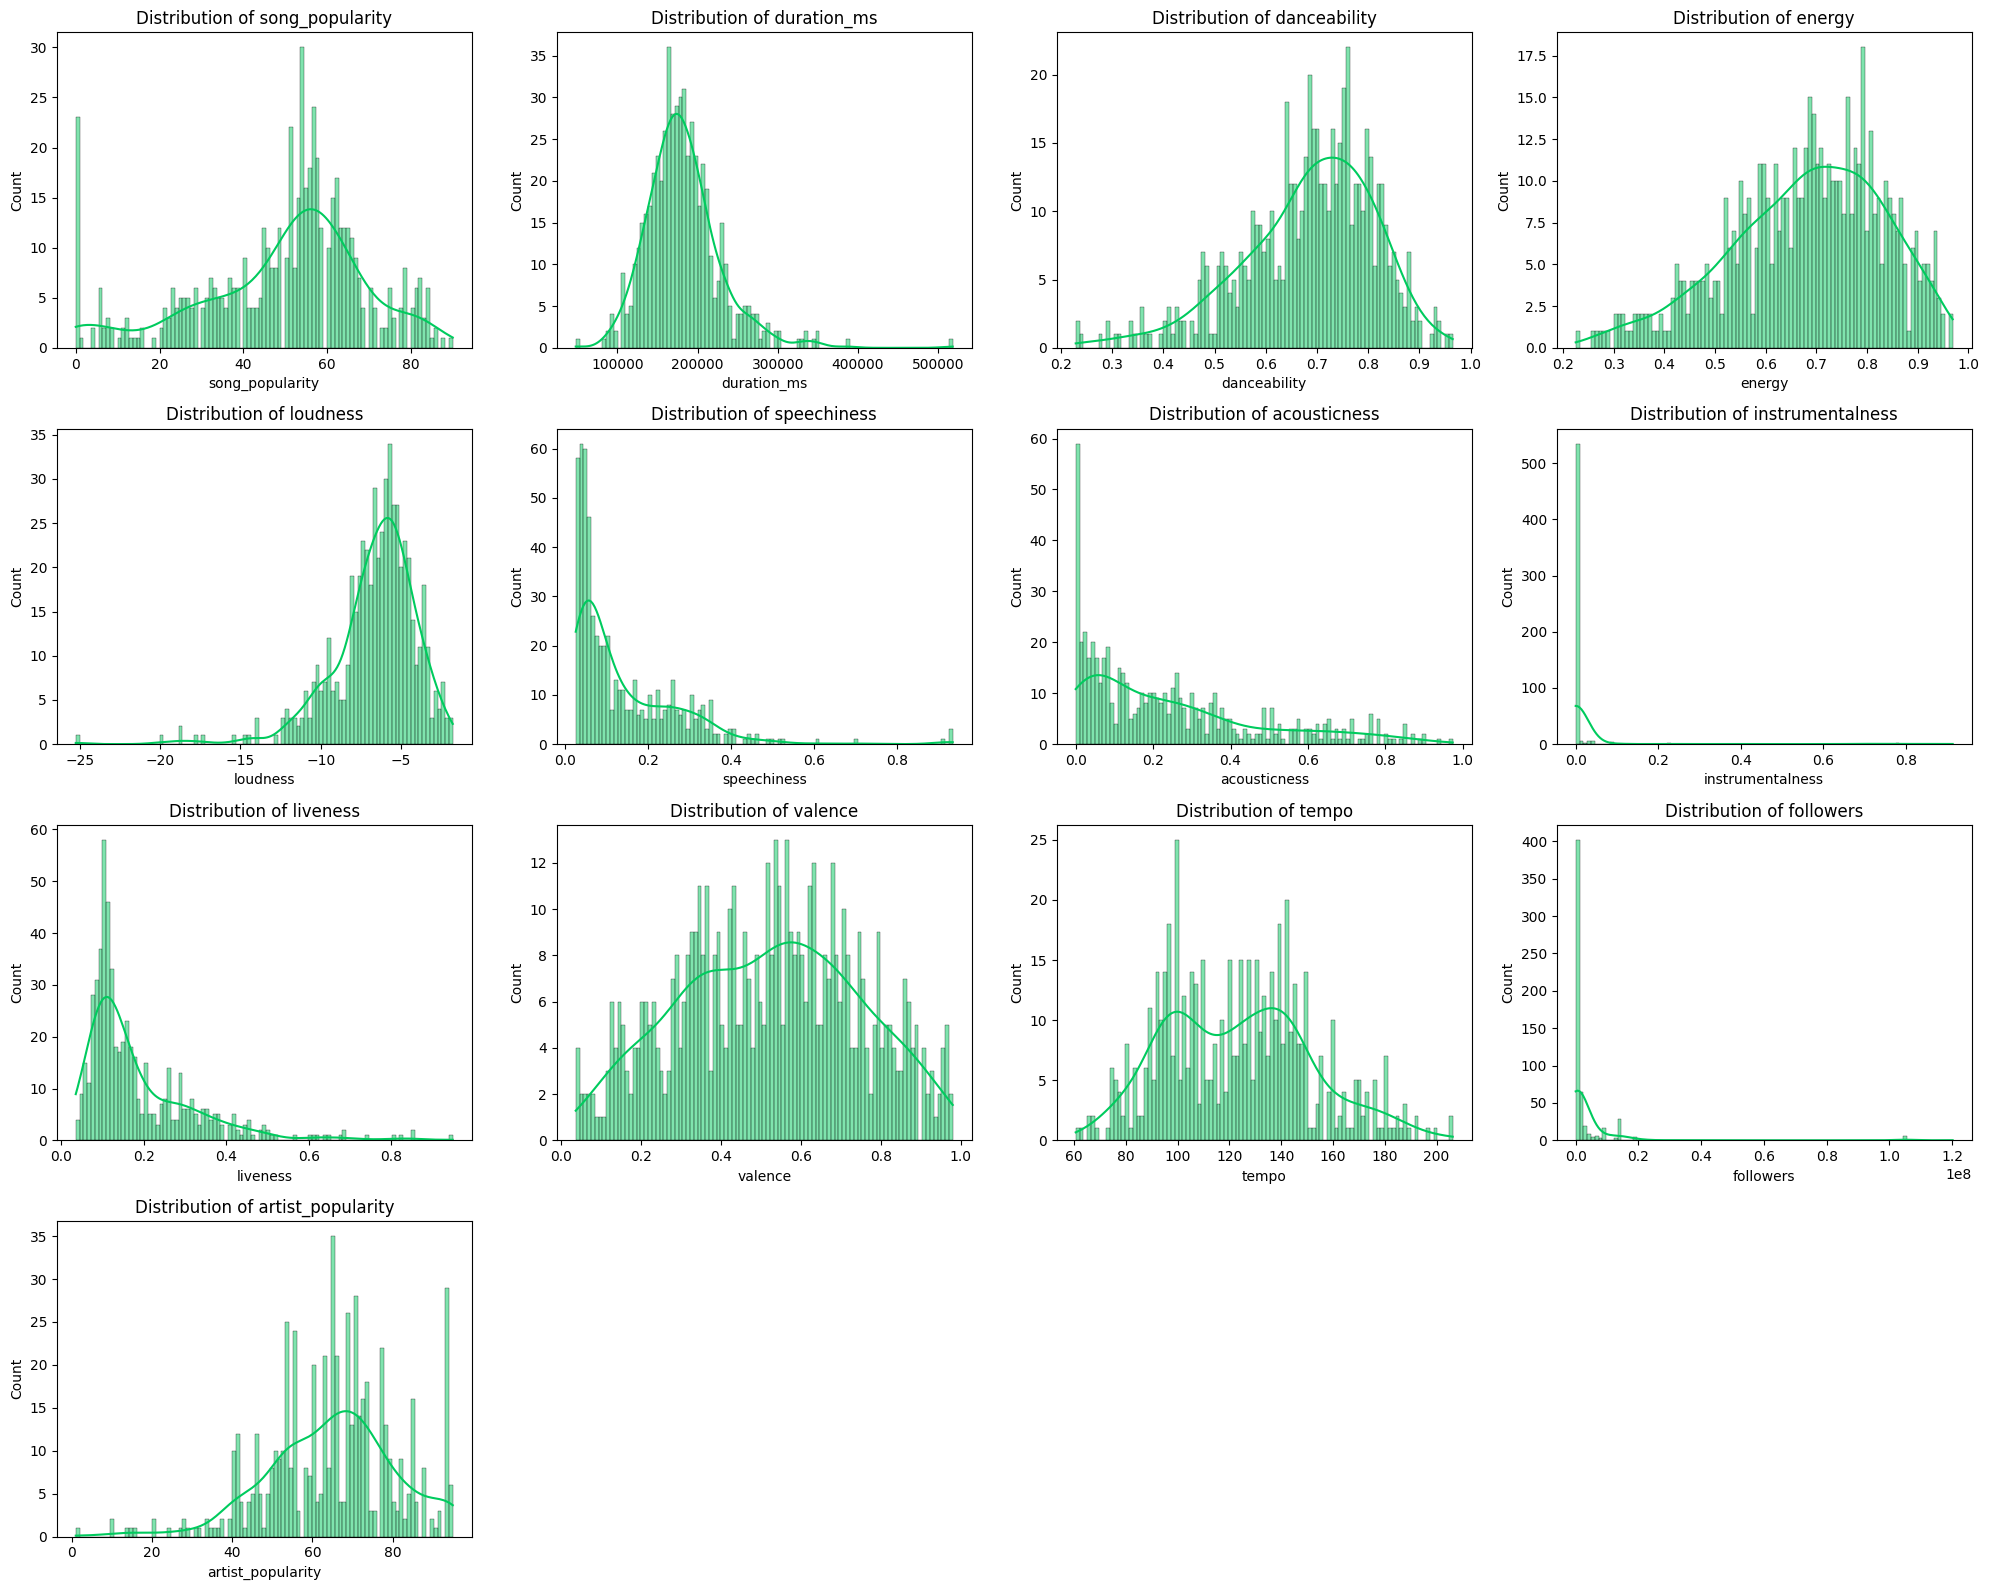

In [13]:
# --- Numeric Histograms ---
df2 = df.drop_duplicates(subset='name')
numeric_cols = df2.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['is_explicit', 'mode', 'key', 'time_signature', 'num_artists']]
cols = 4
rows = math.ceil(len(numeric_cols) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df2[col], kde=True, bins=99, color='#00cb5e', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

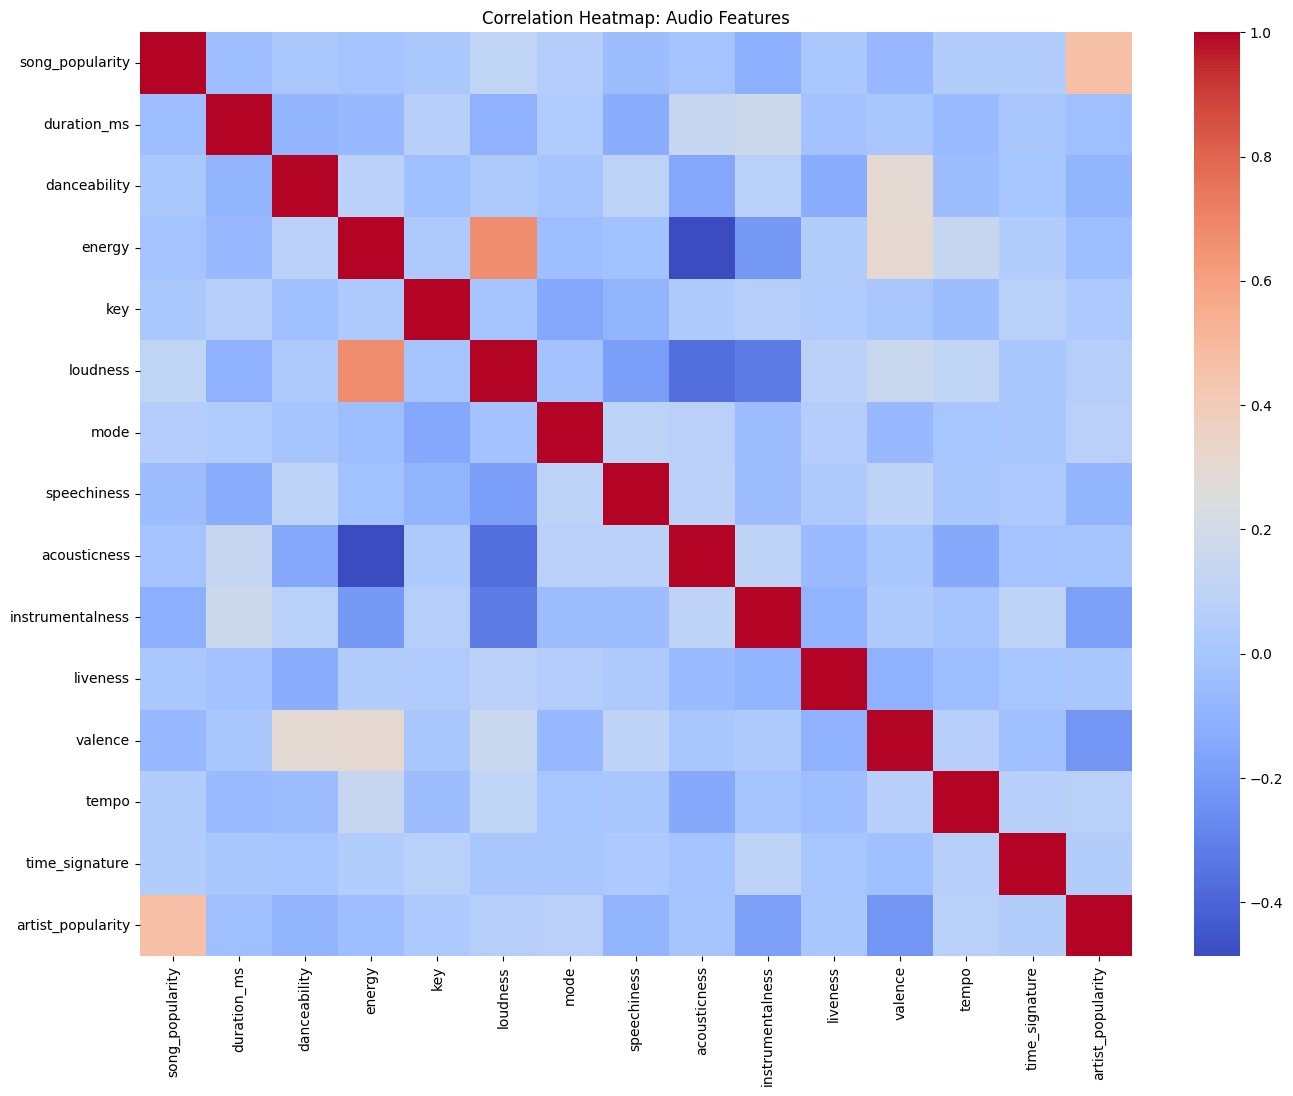

In [14]:
# --- Correlation Heatmaps ---
df_audio = df.drop(columns=['followers', 'artist_popularity'], errors='ignore')
numeric_cols_audio = df_audio.select_dtypes(include='number').columns.tolist()
numeric_cols_audio = [col for col in numeric_cols_audio if col not in ['num_artists']]

plt.figure(figsize=(16, 12))
sns.heatmap(df_audio[numeric_cols_audio].corr(), cmap='coolwarm')
plt.title('Correlation Heatmap: Audio Features')
plt.show()

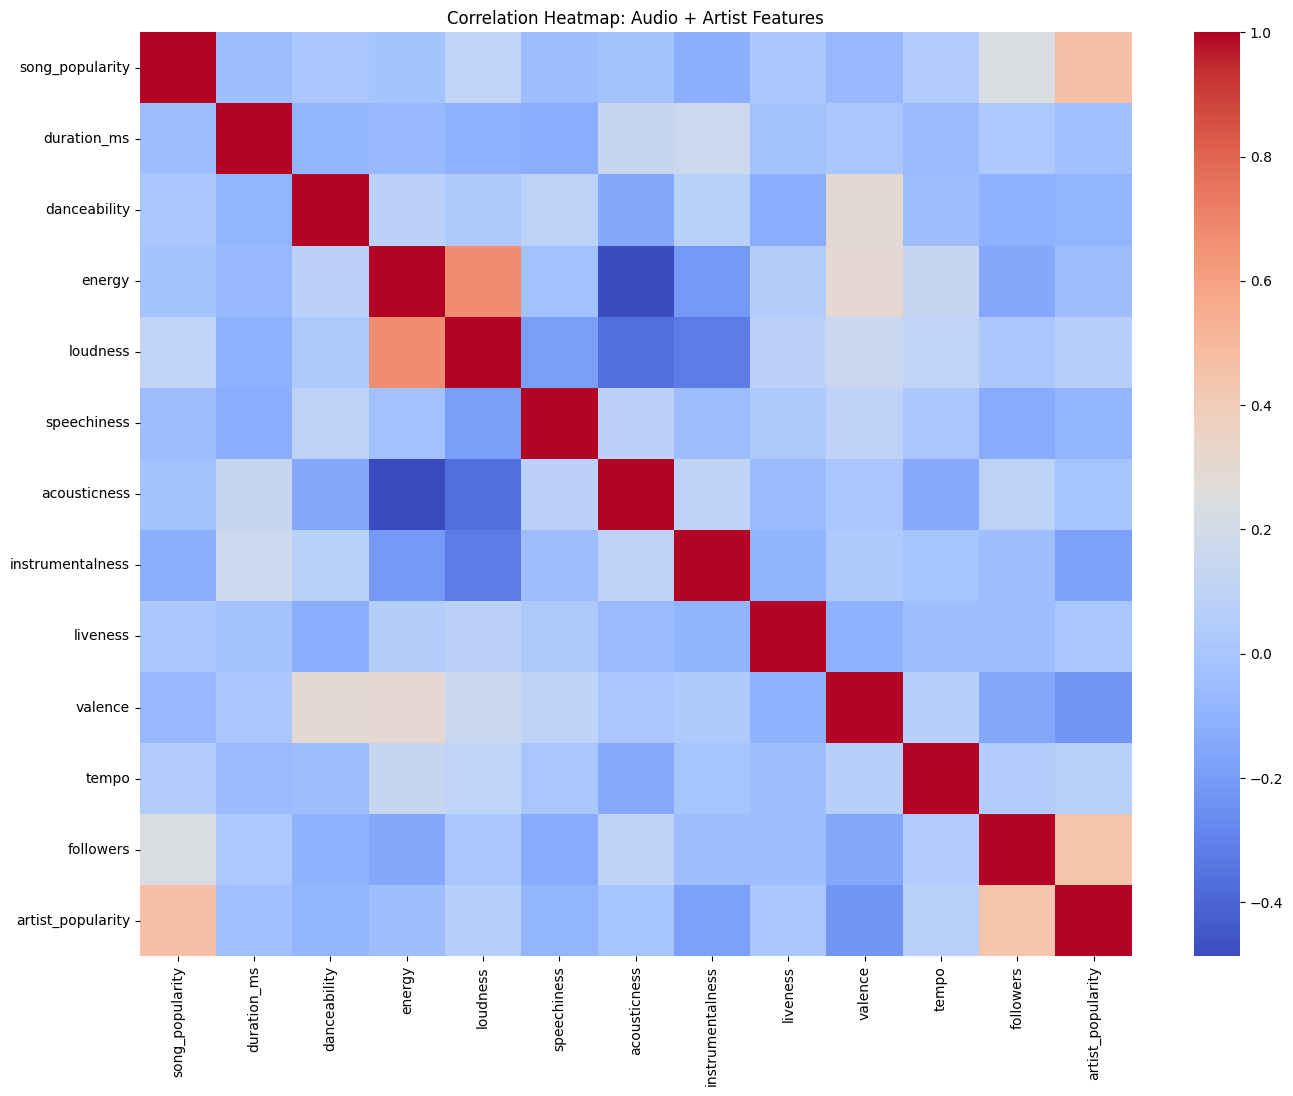

In [15]:
plt.figure(figsize=(16, 12))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm')
plt.title('Correlation Heatmap: Audio + Artist Features')
plt.show()

# Modeling Setup

In [16]:
# =============================
# Modeling
# =============================

# --- Step 1: Clean and prepare modeling dataset ---
df1 = df.copy()

df1 = df1.drop(columns=[
    'genres', 'name', 'artists', 'snapshot_date',
    'album_release_date', 'main_artist'
], errors='ignore')

df1 = df1.dropna()
df1['is_explicit'] = df1['is_explicit'].astype(int)

# Rename for clarity
df1 = df1.rename(columns={
    'followers': 'artist_followers',
    'duration_ms': 'duration'
})

# Remove songs with no popularity score
df1 = df1[df1['song_popularity'] != 0]

# Binarize popularity
median_popularity = df1['song_popularity'].median()
df1['popularity_binary'] = (df1['song_popularity'] >= median_popularity).astype(int)

# Drop unused or redundant columns
df1 = df1.drop(columns=['song_popularity', 'time_signature', 'instrumentalness', 'num_artists'], errors='ignore')

In [17]:
# --- Step 2: Feature configurations ---
numerical_features_full = [
    'duration', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'liveness', 'valence', 'tempo',
    'artist_followers', 'artist_popularity'
]
numerical_features_no_artist = [
    f for f in numerical_features_full if f not in ['artist_followers', 'artist_popularity']
]
categorical_features = ['key']
binary_features = ['is_explicit', 'mode']

# Model and CV config
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

models_and_grids = {
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'clf__n_estimators': [100], 'clf__max_depth': [None], 'clf__min_samples_split': [2]}
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {'clf__n_estimators': [100], 'clf__learning_rate': [0.1], 'clf__max_depth': [3]}
    ),
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {'clf__C': [1]}
    ),
    'LinearSVC': (
        LinearSVC(dual=False, max_iter=5000, random_state=42),
        {'clf__C': [1]}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'clf__n_neighbors': [5]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {'clf__max_depth': [None], 'clf__min_samples_split': [2]}
    )
}

# Principal Component Analysis

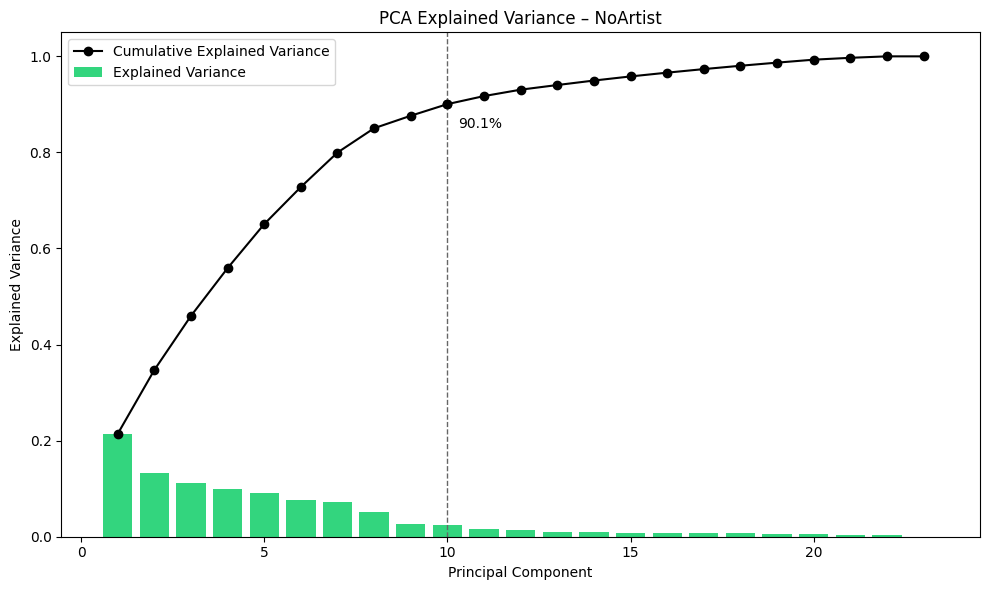

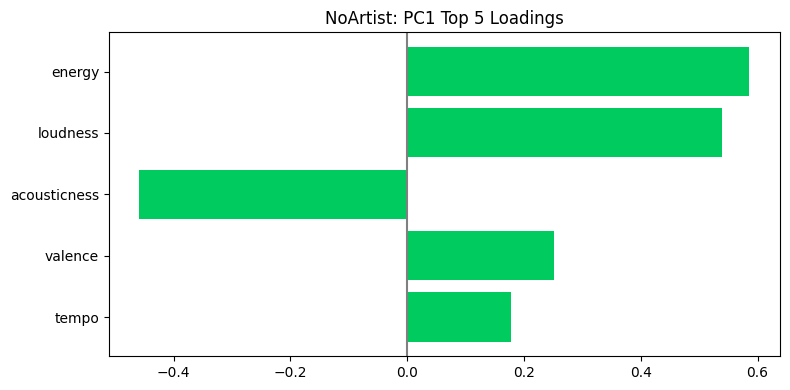

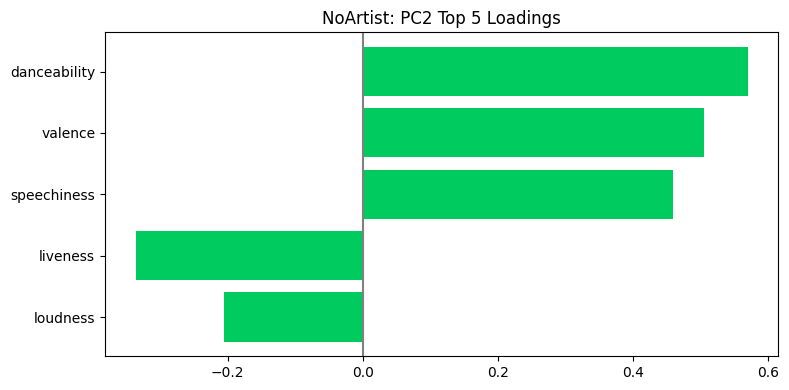

In [18]:
# Run pipeline without artist features
res_na_np, res_na_pca, dt_na, X_na, y_na, feat_na = run_pipeline(numerical_features_no_artist, 'NoArtist')

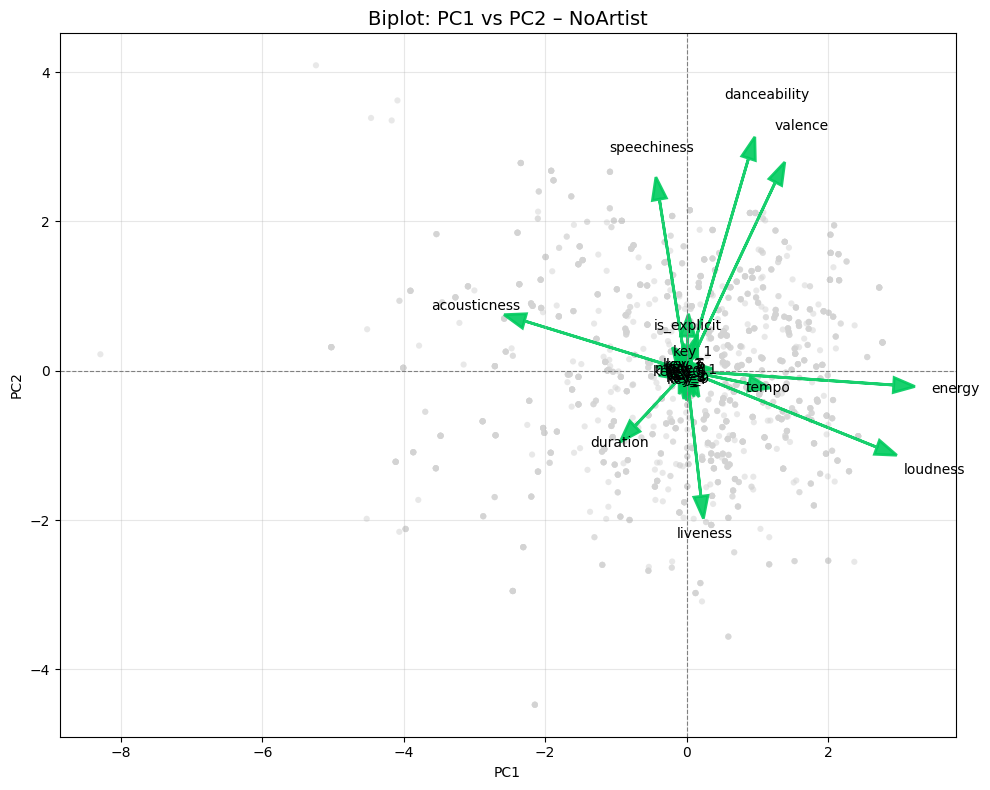

In [19]:
# --- Biplot: NoArtist ---
pre_na = ColumnTransformer([
    ('num', StandardScaler(), numerical_features_no_artist),
    ('cat', OneHotEncoder(), categorical_features),
    ('bin', 'passthrough', binary_features)
])
X_na_proc = pre_na.fit_transform(df1[numerical_features_no_artist + categorical_features + binary_features])
pca_na = PCA().fit(X_na_proc)
X_na_pca = pca_na.transform(X_na_proc)
plot_biplot(X_na_pca, df1['popularity_binary'], pca_na.components_, pre_na.get_feature_names_out(), 'NoArtist')

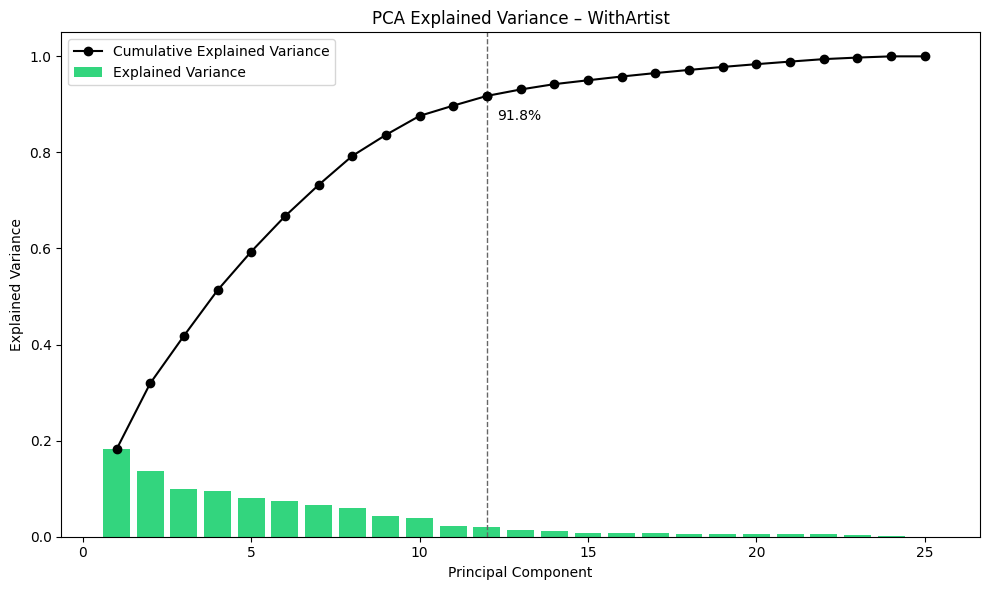

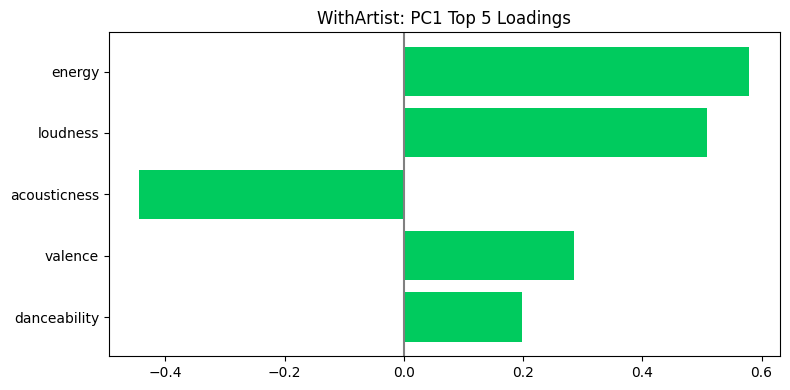

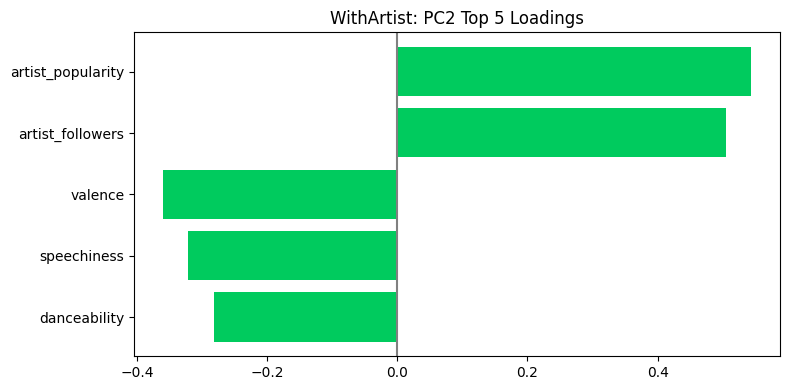

In [20]:
# Run pipeline with artist features
res_wa_np, res_wa_pca, dt_wa, X_wa, y_wa, feat_wa = run_pipeline(numerical_features_full, 'WithArtist')

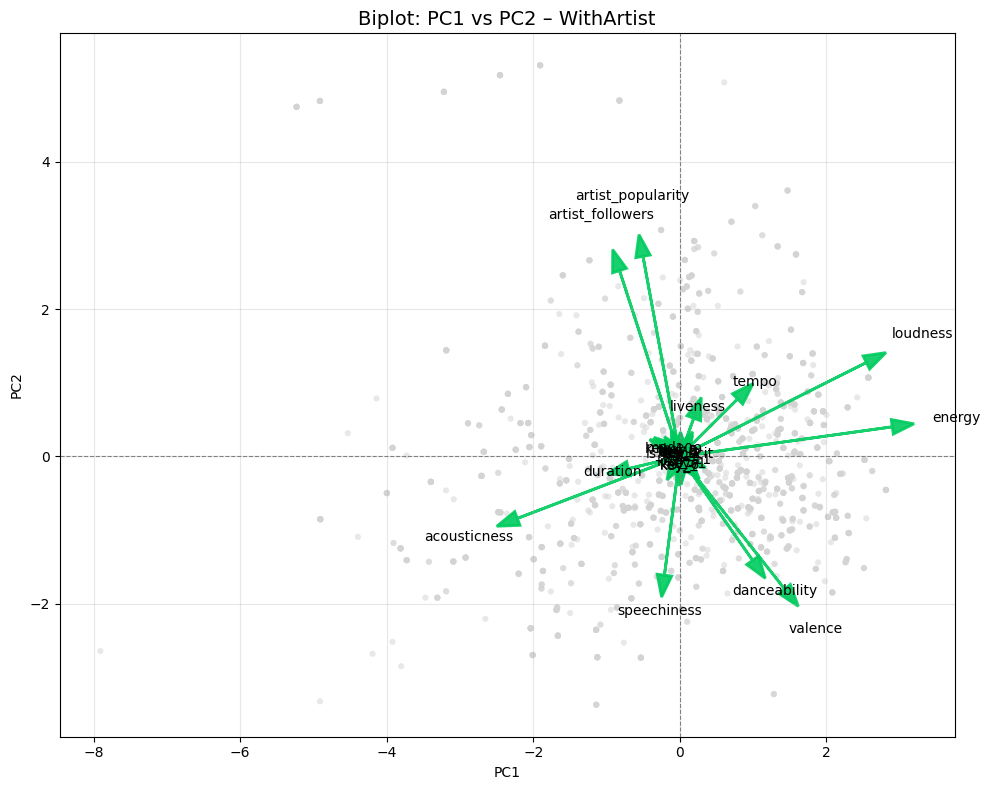

In [21]:
# --- Biplot: WithArtist ---
pre_wa = ColumnTransformer([
    ('num', StandardScaler(), numerical_features_full),
    ('cat', OneHotEncoder(), categorical_features),
    ('bin', 'passthrough', binary_features)
])
X_wa_proc = pre_wa.fit_transform(df1[numerical_features_full + categorical_features + binary_features])
pca_wa = PCA().fit(X_wa_proc)
X_wa_pca = pca_wa.transform(X_wa_proc)
plot_biplot(X_wa_pca, df1['popularity_binary'], pca_wa.components_, pre_wa.get_feature_names_out(), 'WithArtist')

# Models Evaluation

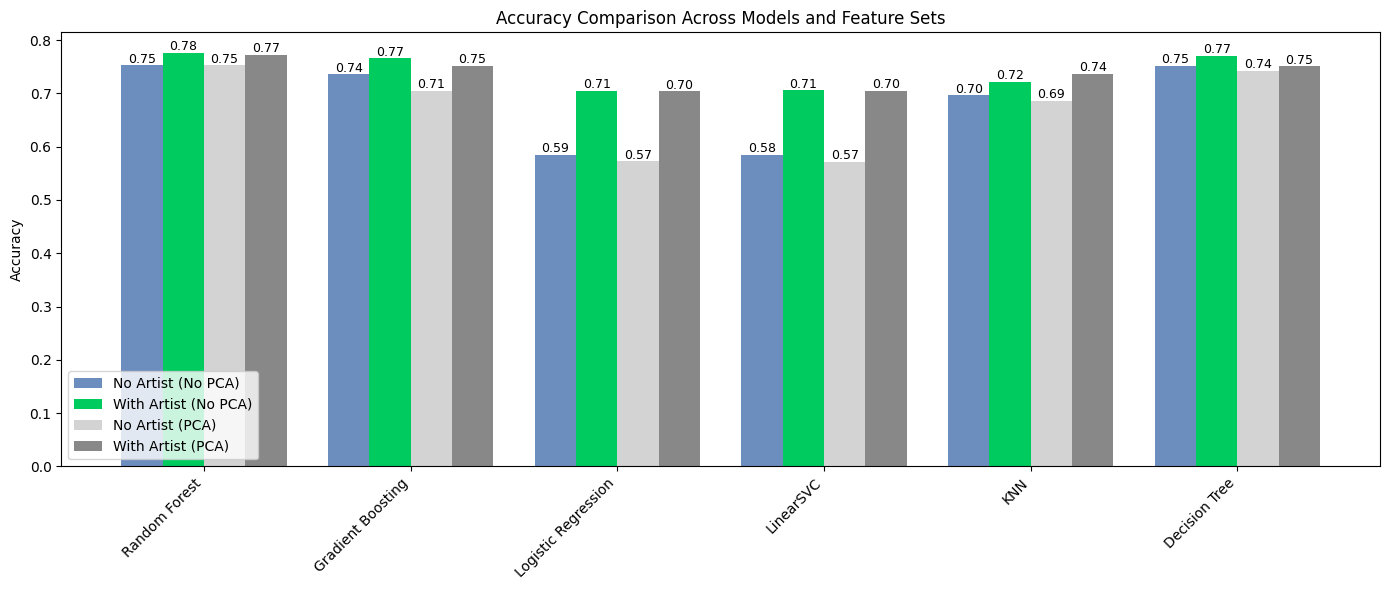

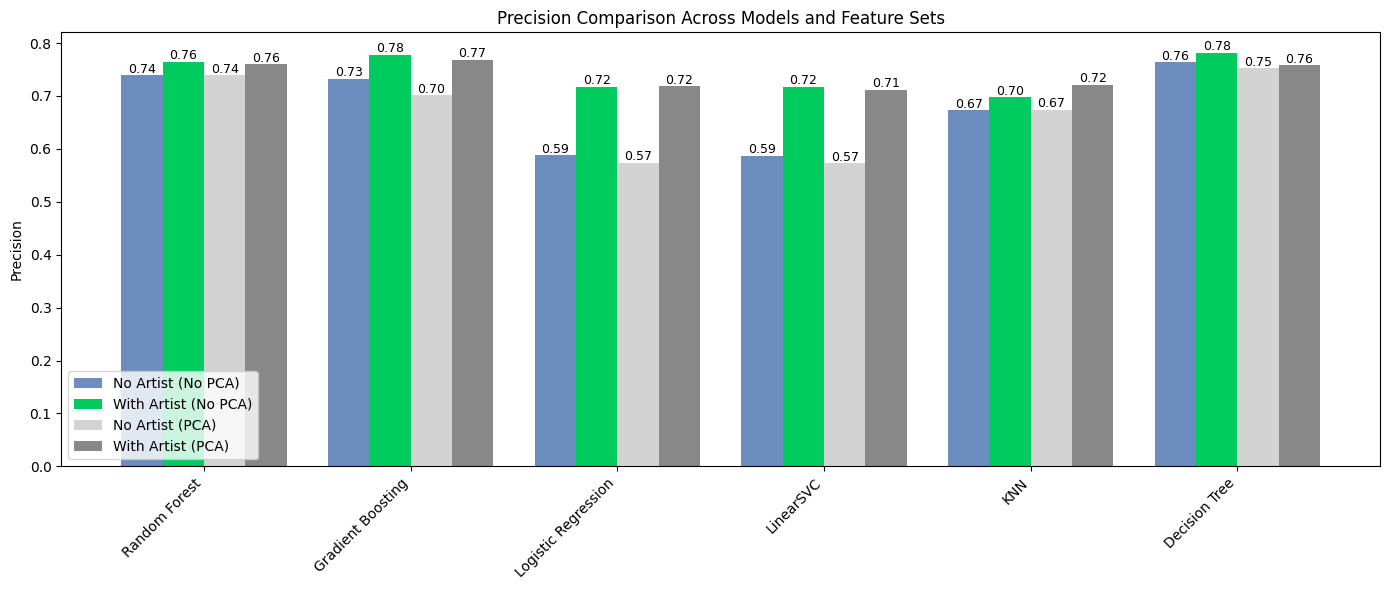

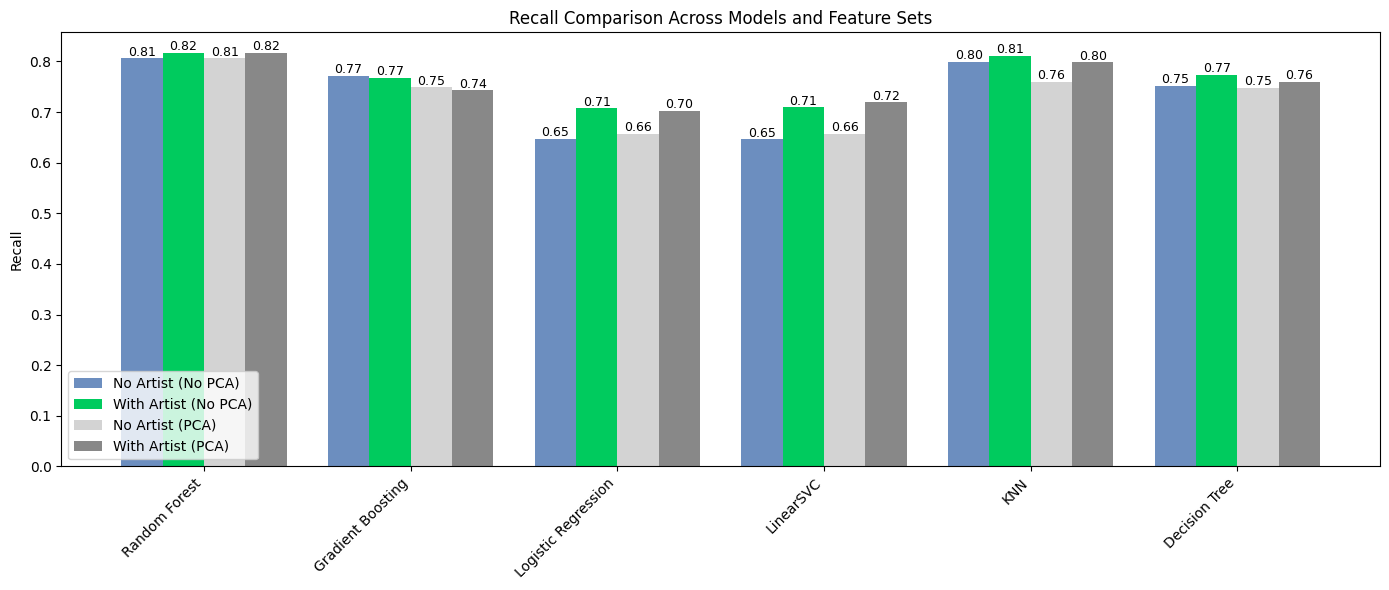

In [22]:
# --- Step 5: Merge and plot model performance ---
merged = res_na_np.merge(res_wa_np, on='Model').merge(res_na_pca, on='Model').merge(res_wa_pca, on='Model')
metrics = [('Acc', 'Accuracy'), ('Prec', 'Precision'), ('Recall', 'Recall')]

for metric, label in metrics:
    plt.figure(figsize=(14, 6))
    idx = np.arange(len(merged))
    bw = 0.2

    bars = [
        plt.bar(idx - 1.5*bw, merged[f'{metric}_NoArtist_NoPCA'], bw, label='No Artist (No PCA)', color='#6c8ebf'),
        plt.bar(idx - 0.5*bw, merged[f'{metric}_WithArtist_NoPCA'], bw, label='With Artist (No PCA)', color='#00cb5e'),
        plt.bar(idx + 0.5*bw, merged[f'{metric}_NoArtist_PCA'], bw, label='No Artist (PCA)', color='#d3d3d3'),
        plt.bar(idx + 1.5*bw, merged[f'{metric}_WithArtist_PCA'], bw, label='With Artist (PCA)', color='#888888')
    ]

    for b in bars:
        for bar in b:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}', ha='center', fontsize=9)

    plt.xticks(idx, merged['Model'], rotation=45, ha='right')
    plt.ylabel(label)
    plt.title(f'{label} Comparison Across Models and Feature Sets')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Feature Importances

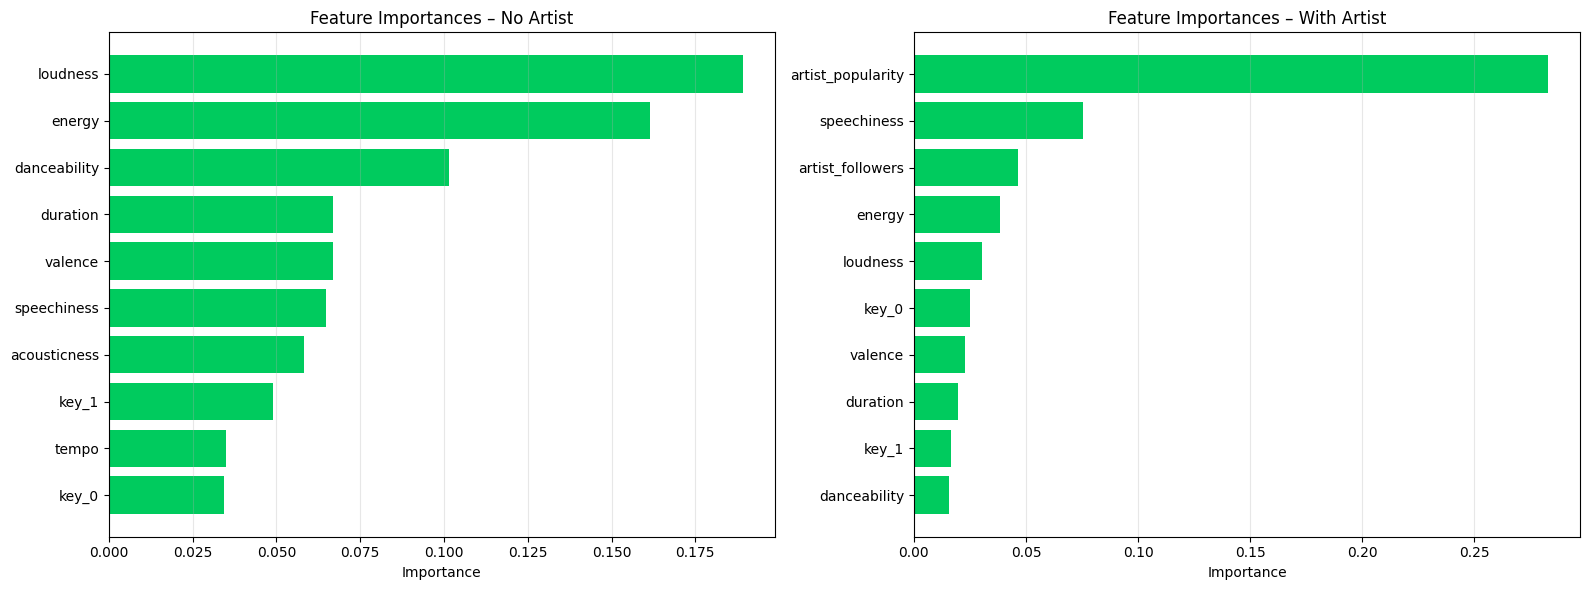

In [23]:
# --- Step 6: Permutation Importances ---
imp_na = plot_perm(dt_na, X_na, y_na, feat_na, 'NoArtist')
imp_wa = plot_perm(dt_wa, X_wa, y_wa, feat_wa, 'WithArtist')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].barh(imp_na['Feature'][::-1], imp_na['Importance'][::-1], color='#00cb5e')
axes[0].set_title('Feature Importances – No Artist')
axes[1].barh(imp_wa['Feature'][::-1], imp_wa['Importance'][::-1], color='#00cb5e')
axes[1].set_title('Feature Importances – With Artist')

for ax in axes:
    ax.set_xlabel('Importance')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()